In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy.stats as stats

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Inits:

In [36]:
full_data = pd.read_pickle('fully_labeled_traces_feats3_071924.pickle') # use for activity comparisons 
# full_data =pd.read_pickle('fully_labeled_traces_feats3_071924_baseline_corrected.pickle') # use for E-I comparisons (does not divide over 0)

# region and indexing-related variables / functions
region_ids = ['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)',
       'BNST (E)', 'BNST (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)',
       'VMHvl (E)', 'VMHvl (I)', 'lPAG (E)', 'lPAG (I)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)', 
       'PA (E)', 'PA (I)', 'NAc (DA)'] # populations
indices = {val: idx for idx, val in enumerate(region_ids)} # dictionary with IDs for remapping
clusters = np.unique(full_data['91R2_d1_balbc_t1']['unsupervised labels'])
print(clusters)
agg_animals = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '91R2', '30L', '30B', '30R2', '29L']
obs_animals = ['30R2', '29L', '86L', '87L2', '927R', '927L', '933R']
non_animals = ['87R2', '87L', '87B', '86L2', '583L2', '583B']

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


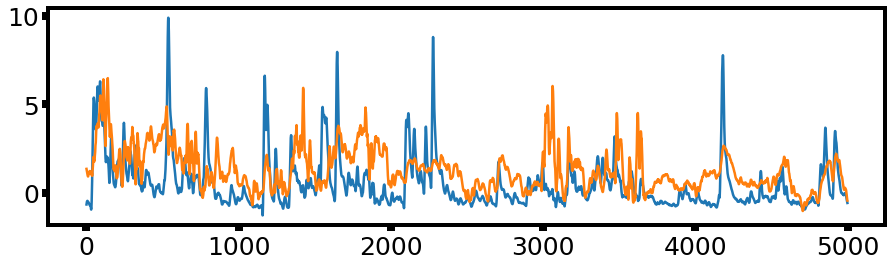

In [5]:
sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})
display(HTML("<style>.container { width:85% !important; }</style>"))

plt.figure(figsize=(15, 4))
plt.plot(full_data['91R2_d8_balbc_t2']['PMv (E)'].values[:5000])
plt.plot(full_data['91R2_d8_balbc_t2']['PMv (I)'].values[:5000])

Get activity for all clusters:

In [7]:
animals = np.concatenate([agg_animals, obs_animals, non_animals])
all_activity = np.zeros((len(clusters), len(region_ids), 27, len(animals)))
all_activity[:] = np.nan

for a, animal in enumerate(animals):
    
    if a<=11:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_balbc_' in x or '_mCD1_' in x]
    elif a<=18:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_obs_' in x or '_OBSmCD1_' in x]
    else:
        sessions = [x for x in list(full_data.keys()) if animal in x if '_toy_' in x or '_toyCD1_' in x]
        
    for s, session in enumerate(sessions):
        
        sample = full_data[session]
        activity_per_cluster = np.zeros((len(clusters), all_activity.shape[1]))

        for i, c in enumerate(clusters):
            idxs2extract = np.where(sample['unsupervised labels'] == c)[0]
            for r, roi in enumerate(region_ids):
                if len(idxs2extract)==0:
                    activity_per_cluster[i, r] = 0
                else:
                    activity_per_cluster[i, r] = np.nanmean(sample[roi].iloc[idxs2extract])

        # Perform ranking
        all_activity[:, :, s, a] = activity_per_cluster
        

C:\Users\Jorge\AppData\Local\Temp\ipykernel_71000\4246832146.py:25: RuntimeWarning: Mean of empty slice
  activity_per_cluster[i, r] = np.nanmean(sample[roi].iloc[idxs2extract])


### Assessing baseline activation of aggression

1. Set up data

In [194]:
def compute_activity(grid, n_clusters, n_animals=12):

    activity_grid = np.zeros((len(n_clusters), len(region_ids), grid.shape[2], n_animals))
    activity_grid[:] = np.nan

    for a in range(grid.shape[-1]):
        for i, idx in enumerate(region_ids): # E indices
            activity = grid[n_clusters, i, :, a] # if clusters are selected monotonically
            activity_grid[:, i, :, a] = activity

    return activity_grid

# For computing EI indices
total_sessions = 27
n_animals = 25
n_rois = len(region_ids)

# Gra activity during aggression subclusters
n_clusters = [1, 2, 3, 7]
# n_clusters = np.arange(8)
prep_activity_data = compute_activity(all_activity, n_clusters=np.array(n_clusters), n_animals=n_animals) 
n_clusters = [10, 11, 12]
asocial_activity_data = compute_activity(all_activity, n_clusters=np.array(n_clusters), n_animals=n_animals)

# For saving
prep_dists = np.zeros((total_sessions, n_rois, n_animals))
prep_dists[:] = np.nan
asocial_dists = prep_dists.copy()

for animal in np.arange(prep_activity_data.shape[-1]):
    for roi in np.arange(n_rois):
        sample1 = prep_activity_data[:, roi, :, animal]
        sample2 = asocial_activity_data[:, roi, :, animal]
        for i in enumerate(np.arange(sample1.shape[1])):
            prep_dists[i,roi,animal] = np.mean(prep_activity_data[:, roi, i, animal])
            asocial_dists[i,roi,animal] = np.mean(asocial_activity_data[:, roi, i, animal])

all_dists = prep_dists - asocial_dists
# all_dists = prep_dists.copy()
all_dists = np.where(all_dists<=0, 0, all_dists)
# all_dists = prep_dists

In [184]:
aggression_related_activity = all_dists[:-3, :, :]
aggression_related_activity = np.nanmean(aggression_related_activity, axis=0)
agg_activity = aggression_related_activity[:, np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]
obs_activity = aggression_related_activity[:, np.array([12, 13, 14, 15, 16, 17, 18])]
non_activity = aggression_related_activity[:, np.array([19, 20, 21, 22, 23, 24])]

C:\Users\Jorge\AppData\Local\Temp\ipykernel_71000\1757351912.py:2: RuntimeWarning: Mean of empty slice
  aggression_related_activity = np.nanmean(aggression_related_activity, axis=0)


2. Descriptive plotting (Fig 3)

In [185]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Get the YlOrBr colormap
cmap = plt.cm.get_cmap('YlOrBr')

# Create a new colormap from the existing colormap
colors = cmap(np.linspace(0, 1, cmap.N))

# Change the first color to white
colors[0] = (1, 1, 1, 1)  # RGBA color

# Create a new colormap from the modified color list
cmap_white = mcolors.LinearSegmentedColormap.from_list('YlOrBr_white', colors)

C:\Users\Jorge\AppData\Local\Temp\ipykernel_71000\2576748501.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlOrBr')


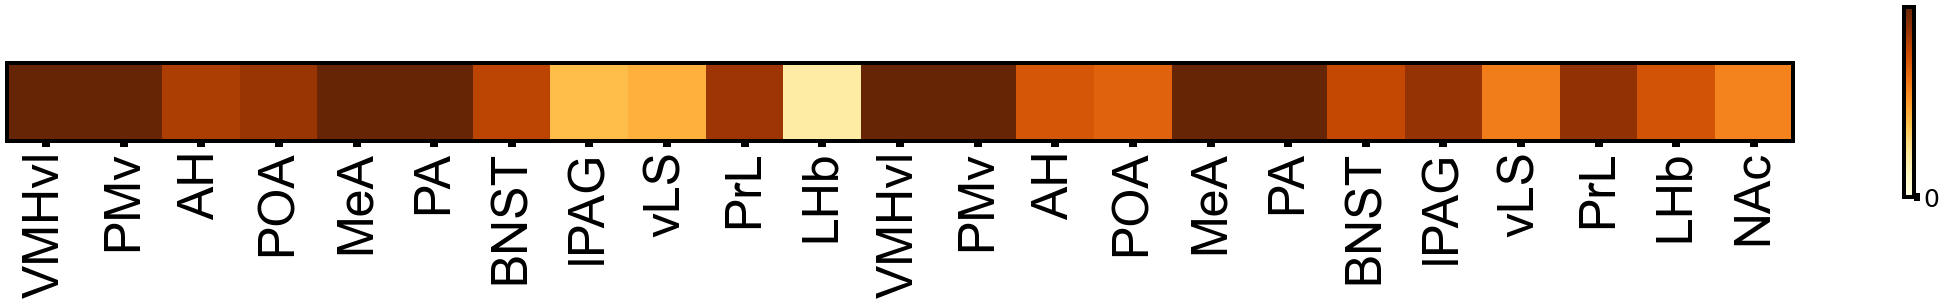

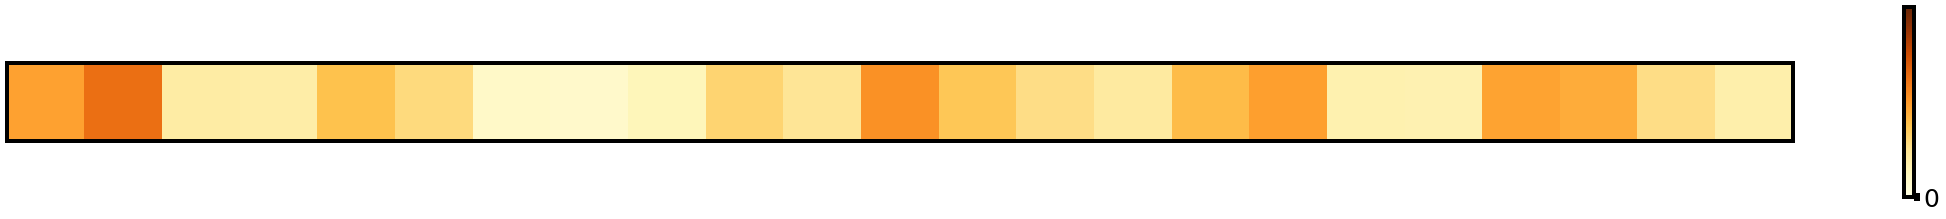

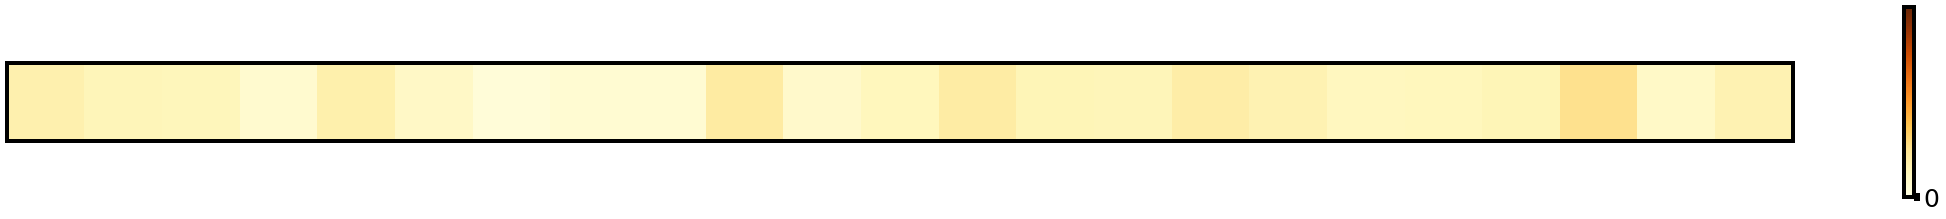

In [186]:
from matplotlib import colors
np.set_printoptions(precision=4, suppress=True)
idxs2loop = np.array([12, 16, 10, 20, 0, 14, 8, 4, 6, 2, 18, 13, 17, 11, 21, 1, 15, 9, 5, 7, 3, 19, 22])
idxs2loop = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 22])
n = len(region_ids)
# cmap = cmap_white
vmin = 0
vmax = 0.5
all_labels = np.array([x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for x in region_ids])[idxs2loop]

# within-day change

weights = np.nanmean(agg_activity, axis=1)
weights_sorted = weights[idxs2loop]
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 0.75, 1.5])
cbar.set_ticklabels([0, 0.75, 1.5])
ax.set_xticks(np.arange(n), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
# plt.gca().invert_yaxis()
# plt.gca().xaxis.tick_top()
# plt.savefig('./figures/fig3/agg_aggroCluster_norm_activity.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(obs_activity, axis=1)
weights_sorted = weights[idxs2loop]
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 0.75, 1.5])
cbar.set_ticklabels([0, 0.75, 1.5])
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
# plt.savefig('./figures/fig3/obs_aggroCluster_norm_activity.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(non_activity, axis=1)
weights_sorted = weights[idxs2loop]
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 0.75, 1.5])
cbar.set_ticklabels([0, 0.75, 1.5])
# plt.xticks(np.arange(n), np.array(regions_without_label)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
# plt.savefig('./figures/fig3/non_aggroCluster_norm_activity.svg', dpi=600, bbox_inches='tight')




In [165]:
# run stats

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

p_values = []  # List to collect all p-values
t_values = []  # List to collect all t-values
test_types = []  # List to collect all test types

# Assuming your vectors are named vector1, vector2, and vector3
for r, roi in enumerate(region_ids):
    print(roi)
    agg_roi_activity = agg_activity[r, :][np.isnan(agg_activity[r, :])==False]
    print(agg_roi_activity.shape)
    obs_roi_activity = obs_activity[r, :][np.isnan(obs_activity[r, :])==False]
    print(obs_roi_activity.shape)
    non_roi_activity = non_activity[r, :][np.isnan(non_activity[r, :])==False]
    print(non_roi_activity.shape)

    # Test for normality
    _, p_agg = stats.shapiro(agg_roi_activity)
    _, p_obs = stats.shapiro(obs_roi_activity)
    _, p_non = stats.shapiro(non_roi_activity)

    # If the p-value is greater than 0.05, the data is normally distributed
    if p_agg > 0.05 and p_non > 0.05:
        # Perform t-tests
        t1, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
        test_type1='t' 
        
    else:
        # Perform Wilcoxon rank-sum tests
        t1, p_agg_non = stats.mannwhitneyu(agg_roi_activity, non_roi_activity)
        test_type1='U'

    p_values.append(p_agg_non)
    t_values.append(t1)
    test_types.append(test_type1)

    if p_obs > 0.05 and p_non > 0.05:
        # Perform t-tests
        t2, p_obs_non = stats.ttest_ind(obs_roi_activity, non_roi_activity)
        test_type2='t'
    
    else:
        # Perform Wilcoxon rank-sum tests
        t2, p_obs_non = stats.mannwhitneyu(obs_roi_activity, non_roi_activity)
        test_type2='U'

    p_values.append(p_obs_non)
    t_values.append(t2)
    test_types.append(test_type2)

PrL (E)
(11,)
(7,)
(6,)
PrL (I)
(11,)
(7,)
(6,)
vLS (E)
(12,)
(7,)
(6,)
vLS (I)
(12,)
(7,)
(6,)
POA (E)
(11,)
(7,)
(6,)
POA (I)
(11,)
(7,)
(6,)
BNST (E)
(10,)
(7,)
(6,)
BNST (I)
(10,)
(7,)
(6,)
AH (E)
(10,)
(7,)
(6,)
AH (I)
(10,)
(7,)
(6,)
MeA (E)
(11,)
(7,)
(6,)
MeA (I)
(11,)
(7,)
(6,)
VMHvl (E)
(12,)
(7,)
(6,)
VMHvl (I)
(12,)
(7,)
(6,)
lPAG (E)
(8,)
(7,)
(6,)
lPAG (I)
(8,)
(7,)
(6,)
PMv (E)
(8,)
(7,)
(6,)
PMv (I)
(8,)
(7,)
(6,)
LHb (E)
(9,)
(7,)
(6,)
LHb (I)
(9,)
(7,)
(6,)
PA (E)
(9,)
(7,)
(6,)
PA (I)
(9,)
(7,)
(6,)
NAc (DA)
(11,)
(7,)
(6,)


In [166]:
# correct for multiple comparisons
pvals_uncorrected = np.array(p_values)
pvals_uncorrected_AGG = pvals_uncorrected[0::2]
pvals_uncorrected_OBS = pvals_uncorrected[1::2]
reject, pvals_corrected, _, _ = multipletests(p_values, method='fdr_tsbh')
pvals_corrected_AGG = pvals_corrected[0::2]
pvals_corrected_OBS = pvals_corrected[1::2]
tvals_AGG = t_values[0::2]
tvals_OBS = t_values[1::2]
test_types_AGG = test_types[0::2]
test_types_OBS = test_types[1::2]
idxs2loop = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 22])

### AGG
for i, p in enumerate(idxs2loop):
    print('%s AGG vs NON; %s = %f, p = %f' % (region_ids[p], test_types_AGG[p], tvals_AGG[p], pvals_corrected_AGG[p]))

### OBS
for i, p in enumerate(idxs2loop):
    print('%s OBS vs NON; %s = %f, p = %f' % (region_ids[p], test_types_OBS[p], tvals_OBS[p], pvals_corrected_OBS[p]))

VMHvl (E) AGG vs NON; t = 5.023741, p = 0.000687
PMv (E) AGG vs NON; U = 48.000000, p = 0.001127
AH (E) AGG vs NON; t = 3.751760, p = 0.002777
POA (E) AGG vs NON; t = 4.913255, p = 0.000687
MeA (E) AGG vs NON; t = 4.874893, p = 0.000687
PA (E) AGG vs NON; t = 4.563172, p = 0.001064
BNST (E) AGG vs NON; t = 3.801339, p = 0.002675
lPAG (E) AGG vs NON; t = 3.509862, p = 0.005259
vLS (E) AGG vs NON; t = 4.698903, p = 0.000687
PrL (E) AGG vs NON; U = 66.000000, p = 0.000687
LHb (E) AGG vs NON; t = 1.425301, p = 0.126064
VMHvl (I) AGG vs NON; t = 5.378387, p = 0.000677
PMv (I) AGG vs NON; t = 4.296178, p = 0.001524
AH (I) AGG vs NON; t = 7.274587, p = 0.000089
POA (I) AGG vs NON; t = 2.860473, p = 0.011911
MeA (I) AGG vs NON; t = 4.581073, p = 0.000879
PA (I) AGG vs NON; t = 4.211213, p = 0.001524
BNST (I) AGG vs NON; U = 60.000000, p = 0.000687
lPAG (I) AGG vs NON; t = 2.980201, p = 0.011911
vLS (I) AGG vs NON; t = 3.045596, p = 0.008480
PrL (I) AGG vs NON; U = 64.000000, p = 0.001127
LHb (

3. Longitudinal changes? (LME model)

In [75]:
# split data into groups/days ; group sessions by day

mean_func = np.nanmean

agg_d1 = mean_func(all_dists[0:3, :, np.arange(12)], axis=0)
obs_d1 = mean_func(all_dists[0:3, :, np.arange(12, 19)], axis=0)
non_d1 = mean_func(all_dists[0:3, :, np.arange(19, 25)], axis=0)
d1 = np.concatenate([agg_d1, obs_d1, non_d1], axis=1)

agg_d2 = mean_func(all_dists[3:6, :, np.arange(12)], axis=0)
obs_d2 = mean_func(all_dists[3:6, :, np.arange(12, 19)], axis=0)
non_d2 = mean_func(all_dists[3:6, :, np.arange(19, 25)], axis=0)
d2 = np.concatenate([agg_d2, obs_d2, non_d2], axis=1)

agg_d3 = mean_func(all_dists[6:9, :, np.arange(12)], axis=0)
obs_d3 = mean_func(all_dists[6:9, :, np.arange(12, 19)], axis=0)
non_d3 = mean_func(all_dists[6:9, :, np.arange(19, 25)], axis=0)
d3 = np.concatenate([agg_d3, obs_d3, non_d3], axis=1)

agg_d4 = mean_func(all_dists[9:12, :, np.arange(12)], axis=0)
obs_d4 = mean_func(all_dists[9:12, :, np.arange(12, 19)], axis=0)
non_d4 = mean_func(all_dists[9:12, :, np.arange(19, 25)], axis=0)
d4 = np.concatenate([agg_d4, obs_d4, non_d4], axis=1)

agg_d5 = mean_func(all_dists[12:15, :, np.arange(12)], axis=0)
obs_d5 = mean_func(all_dists[12:15, :, np.arange(12, 19)], axis=0)
non_d5 = mean_func(all_dists[12:15, :, np.arange(19, 25)], axis=0)
d5 = np.concatenate([agg_d5, obs_d5, non_d5], axis=1)

agg_d6 = mean_func(all_dists[15:18, :, np.arange(12)], axis=0)
obs_d6 = mean_func(all_dists[15:18, :, np.arange(12, 19)], axis=0)
non_d6 = mean_func(all_dists[15:18, :, np.arange(19, 25)], axis=0)
d6 = np.concatenate([agg_d6, obs_d6, non_d6], axis=1)

agg_d7 = mean_func(all_dists[18:21, :, np.arange(12)], axis=0)
obs_d7 = mean_func(all_dists[18:21, :, np.arange(12, 19)], axis=0)
non_d7 = mean_func(all_dists[18:21, :, np.arange(19, 25)], axis=0)
d7 = np.concatenate([agg_d7, obs_d7, non_d7], axis=1)

agg_d8 = mean_func(all_dists[21:24, :, np.arange(12)], axis=0)
obs_d8 = mean_func(all_dists[21:24, :, np.arange(12, 19)], axis=0)
non_d8 = mean_func(all_dists[21:24, :, np.arange(19, 25)], axis=0)
d8 = np.concatenate([agg_d8, obs_d8, non_d8], axis=1)


C:\Users\Jorge\AppData\Local\Temp\ipykernel_71000\906061547.py:5: RuntimeWarning: Mean of empty slice
  agg_d1 = mean_func(all_dists[0:3, :, np.arange(12)], axis=0)
C:\Users\Jorge\AppData\Local\Temp\ipykernel_71000\906061547.py:10: RuntimeWarning: Mean of empty slice
  agg_d2 = mean_func(all_dists[3:6, :, np.arange(12)], axis=0)
C:\Users\Jorge\AppData\Local\Temp\ipykernel_71000\906061547.py:15: RuntimeWarning: Mean of empty slice
  agg_d3 = mean_func(all_dists[6:9, :, np.arange(12)], axis=0)
C:\Users\Jorge\AppData\Local\Temp\ipykernel_71000\906061547.py:20: RuntimeWarning: Mean of empty slice
  agg_d4 = mean_func(all_dists[9:12, :, np.arange(12)], axis=0)
C:\Users\Jorge\AppData\Local\Temp\ipykernel_71000\906061547.py:25: RuntimeWarning: Mean of empty slice
  agg_d5 = mean_func(all_dists[12:15, :, np.arange(12)], axis=0)
C:\Users\Jorge\AppData\Local\Temp\ipykernel_71000\906061547.py:30: RuntimeWarning: Mean of empty slice
  agg_d6 = mean_func(all_dists[15:18, :, np.arange(12)], axis=0)


In [76]:
import statsmodels.stats.multitest as smm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

### trying LME with all groups

# Gather tables
all_tables = {}
EI_regions = region_ids.copy()
animals2exclude = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
sessions2exclude = [0, -3] # for NON
all_tables = []
for roi in EI_regions:
    table = pd.DataFrame(columns=['cross_day', 'cross_session', 'within_day', 'subject', 'dependent_variable'])
    for animal in np.arange((len(np.concatenate([agg_animals, obs_animals, non_animals]))))[animals2exclude]:
        sample = all_dists[sessions2exclude[0]:sessions2exclude[1], EI_regions.index(roi), animal]
        cross_day_info = np.repeat(np.arange(9), 3)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        within_day_info = np.tile(np.arange(3), 9)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        session_info = np.arange(27)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        subject_info = np.repeat(animal, 27)[sessions2exclude[0]:sessions2exclude[1]]
        if animal<=11:
            group_info = np.repeat(0, 27)[sessions2exclude[0]:sessions2exclude[1]]
        elif animal<=18:
            group_info = np.repeat(1, 27)[sessions2exclude[0]:sessions2exclude[1]]
        else:
            group_info = np.repeat(2, 27)[sessions2exclude[0]:sessions2exclude[1]]
        table = pd.concat([table, pd.DataFrame({'cross_day': cross_day_info, 'cross_session': session_info, 'within_day': within_day_info, 'subject': subject_info, 'exp_group': group_info, 'dependent_variable': sample})])
    all_tables.append(table)

In [77]:
from statsmodels.stats.anova import AnovaRM
from statsmodels.regression.mixed_linear_model import MixedLM

agg_dbd = [x[:, :12].reshape(23, 12, 1) for x in [d1, d2, d3, d4, d5, d6, d7, d8]]
agg_dbd = np.concatenate(agg_dbd, axis=-1)

obs_dbd = [x[:, 12:19].reshape(23, 7, 1) for x in [d1, d2, d3, d4, d5, d6, d7, d8]]
obs_dbd = np.concatenate(obs_dbd, axis=-1)

ascending_idx_E = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18, 22])
ascending_idx_I = (ascending_idx_E + 1)[:-1]

data4stats = [agg_dbd.copy(), obs_dbd.copy()]

p_values = []
for roi in np.arange(23):
    print('############ %s ############' % region_ids[roi])
    for i, d in enumerate(data4stats):
        # remove nans
        data2stat = d[roi]
        n_nans = len(np.unique(np.where(np.isnan(data2stat))[0]))
        data2stat = data2stat[~np.isnan(data2stat)].reshape(data2stat.shape[0]-n_nans, data2stat.shape[1])
        
        # package into DF
        df = pd.DataFrame(data2stat.flatten(), columns=['Measurement'])
        df['Subject'] = np.repeat(np.arange(data2stat.shape[0]), 8)
        df['Time'] = np.tile(np.arange(8), data2stat.shape[0])

        # Perform the repeated measures ANOVA
        # anova = AnovaRM(df, 'Measurement', 'Subject', within=['Time'])
        # res = anova.fit()

        # Alternatively perform mixed LM
        model = MixedLM(df['Measurement'], df[['Time']], groups=df['Subject'])
        res = model.fit()

        if i==0:
            descrip = 'AGG'
        else:
            descrip = 'OBS'
        # print('%s p-value = %f' % (descrip, res.anova_table['Pr > F']['Time']))
        print('%s p-value = %f' % (descrip, res.pvalues['Time']))
        p_values.append(res.pvalues['Time'])

p_values_AGG = np.array(p_values)[::2]
p_values_AGG_E = p_values_AGG[ascending_idx_E]
p_values_AGG_I = p_values_AGG[ascending_idx_I]
p_values_AGG_I = np.append(p_values_AGG_I, 1)

p_values_OBS = np.array(p_values)[1::2]
p_values_OBS_E = p_values_OBS[ascending_idx_E]
p_values_OBS_I = p_values_OBS[ascending_idx_I]
p_values_OBS_I = np.append(p_values_OBS_I, 1)

############ PrL (E) ############
AGG p-value = 0.799883
OBS p-value = 0.743654
############ PrL (I) ############
AGG p-value = 0.349092
OBS p-value = 0.234718
############ vLS (E) ############
AGG p-value = 0.032457
OBS p-value = 0.007706
############ vLS (I) ############
AGG p-value = 0.320464
OBS p-value = 0.146747
############ POA (E) ############
AGG p-value = 0.771786
OBS p-value = 0.036248
############ POA (I) ############
AGG p-value = 0.939922
OBS p-value = 0.054786
############ BNST (E) ############
AGG p-value = 0.089609
OBS p-value = 0.013181
############ BNST (I) ############
AGG p-value = 0.987919
OBS p-value = 0.037787
############ AH (E) ############
AGG p-value = 0.312546
OBS p-value = 0.008189
############ AH (I) ############
AGG p-value = 0.110169
OBS p-value = 0.096178
############ MeA (E) ############
AGG p-value = 0.310780
OBS p-value = 0.737001
############ MeA (I) ############
AGG p-value = 0.041965
OBS p-value = 0.373350
############ VMHvl (E) ############
AGG 

4. Plot (Extended fig 4)

In [78]:
_, p_values_AGG_corrected, _, _ = multipletests(p_values_AGG, method='fdr_tsbh')
p_values_AGG_E_corrected = p_values_AGG_corrected[ascending_idx_E]
p_values_AGG_I_corrected = p_values_AGG_corrected[ascending_idx_I]
p_values_AGG_I_corrected = np.append(p_values_AGG_I_corrected, 1)


_, p_values_OBS_corrected, _, _ = multipletests(p_values_OBS, method='fdr_tsbh')
p_values_OBS_E_corrected = p_values_OBS_corrected[ascending_idx_E]
p_values_OBS_I_corrected = p_values_OBS_corrected[ascending_idx_I]
p_values_OBS_I_corrected = np.append(p_values_OBS_I_corrected, 1)

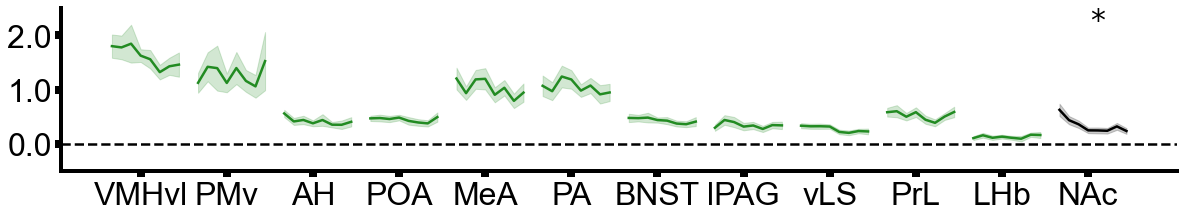

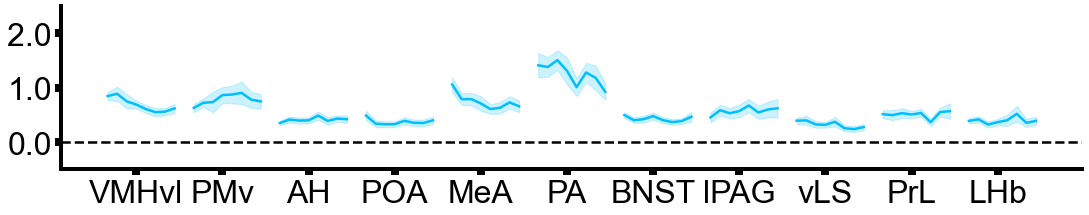

In [97]:
# AGG E and I activity

from scipy.stats import sem

bar_settings = {
    'color': 'white',
    'linewidth': 2.75,
    'capsize': 2.75,
    'error_kw': {'elinewidth': 2.5, 'capsize': 5, 'capthick': 2.5, 'markeredgewidth': 2}}


# Create a figure for the line plots
fig1, ax1 = plt.subplots(figsize=(20, 3))

# Counter for the bar plot positions
bar_counter = 0
factor = 9

indices = []

for t, roi in enumerate([EI_regions[x] for x in ascending_idx_E]):
    element_at_t = np.array([EI_regions[x] for x in ascending_idx_E])[t]
    t_hat = EI_regions.index(element_at_t)
    table = all_tables[t_hat]
    table = table.dropna(axis=0)
    table = table.reset_index(drop=True)

    # Get unique groups
    groups = table['exp_group'].unique()

    # Plot E
    group = 0
    color='forestgreen'
    if t == 11:
        color='black'
    subset = table[table['exp_group'] == group]
    means = subset.groupby('cross_day')['dependent_variable'].mean()
    errors = subset.groupby('cross_day')['dependent_variable'].apply(sem)
    ax1.plot(means.index.values + t*factor, means.values, color=color, linewidth=2.5)
    ax1.fill_between(means.index.values + t*factor, means.values - errors.values, means.values + errors.values, alpha=0.2, color=color)
    indices.append(t*factor)
    
labels=[x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(EI_regions)[ascending_idx_E]]
ax1.set_xticks((np.arange(0, 12*factor, factor)+2)+1, labels, fontsize=32, fontfamily='Arial')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim(top=2.5, bottom=-0.5)
ax1.set_yticks(np.arange(0, 2.2, 1));
ax1.set_yticklabels(np.arange(0, 2.2, 1), fontsize=32, fontfamily='Arial');
ax1.set_yticklabels(np.arange(0, 2.2, 1), fontsize=32, fontfamily='Arial');
ax1.axhline(0, color='black', linestyle='--', linewidth=2.5)

# Adding stars
try:
    for p_value_E, p_value_I, index in zip(p_values_AGG_E_corrected, p_values_AGG_I_corrected, indices):
        # If the p-value is less than 0.05, add a "*" above the line
        if p_value_E < 0.07:
            color = 'forestgreen' if index < 9*11 else 'black'
            if p_value_E < 0.001:
                marker = '***'
            elif p_value_E < 0.01:
                marker = '**'
            elif p_value_E < 0.05:
                marker = '*'
            else:
                marker='#'
            plt.text(index+4, 2, marker, ha='center', va='bottom', fontsize=30, color=color)
        if p_value_I < 0.07:
            if p_value_I < 0.001:
                marker = '***'
            elif p_value_I < 0.01:
                marker = '**'
            elif p_value_I < 0.05:
                marker = '*'
            else:
                marker='#'
            plt.text(index+4, 1.8, marker, ha='center', va='bottom', fontsize=30, color='deepskyblue')
except ValueError:
    pass

fig2, ax2 = plt.subplots(figsize=(18.3, 3))

for t, roi in enumerate([EI_regions[x] for x in ascending_idx_I]):
    element_at_t = np.array([EI_regions[x] for x in ascending_idx_I])[t]
    t_hat = EI_regions.index(element_at_t)
    table = all_tables[t_hat]
    table = table.dropna(axis=0)
    table = table.reset_index(drop=True)

    # Get unique groups
    groups = table['exp_group'].unique()

    # Plot I
    group = 0
    color='deepskyblue'
    subset = table[table['exp_group'] == group]
    means = subset.groupby('cross_day')['dependent_variable'].mean()
    errors = subset.groupby('cross_day')['dependent_variable'].apply(sem)
    ax2.plot(means.index.values + t*factor, means.values, color=color, linewidth=2.5)
    ax2.fill_between(means.index.values + t*factor, means.values - errors.values, means.values + errors.values, alpha=0.2, color=color)
    indices.append(t*factor)

# Cleaning
labels=[x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(EI_regions)[ascending_idx_I]]
ax2.set_xticks((np.arange(0, 11*factor, factor)+2)+1, labels, fontsize=32, fontfamily='Arial')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim(top=2.5, bottom=-0.5)
ax2.set_yticks(np.arange(0, 2.2, 1));
ax2.set_yticklabels(np.arange(0, 2.2, 1), fontsize=32, fontfamily='Arial');
ax2.set_yticklabels(np.arange(0, 2.2, 1), fontsize=32, fontfamily='Arial');
ax2.axhline(0, color='black', linestyle='--', linewidth=2.5)

# Adding stars
try:
    for p_value_E, p_value_I, index in zip(p_values_AGG_E_corrected, p_values_AGG_I_corrected, indices):
        # If the p-value is less than 0.05, add a "*" above the line
        if p_value_I < 0.07:
            if p_value_I < 0.001:
                marker = '***'
            elif p_value_I < 0.01:
                marker = '**'
            elif p_value_I < 0.05:
                marker = '*'
            else:
                marker='#'
            plt.text(index+4, 1.8, marker, ha='center', va='bottom', fontsize=30, color='deepskyblue')
except ValueError:
    pass

# Save fig1 as an SVG file
fig1.savefig('./figures/EXP_exc_activity_changes.svg', format='svg')
fig2.savefig('./figures/EXP_inh_activity_changes.svg', format='svg')

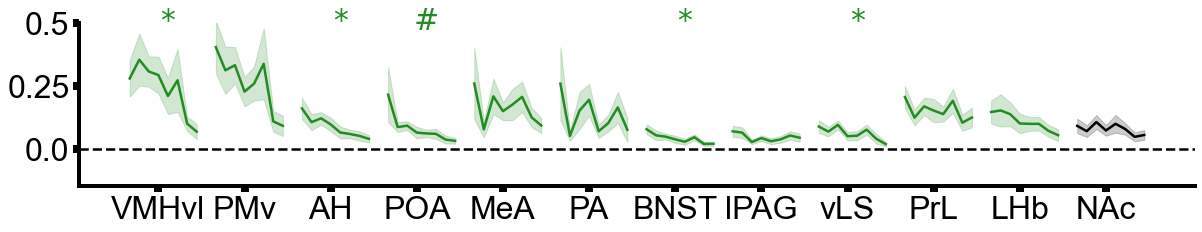

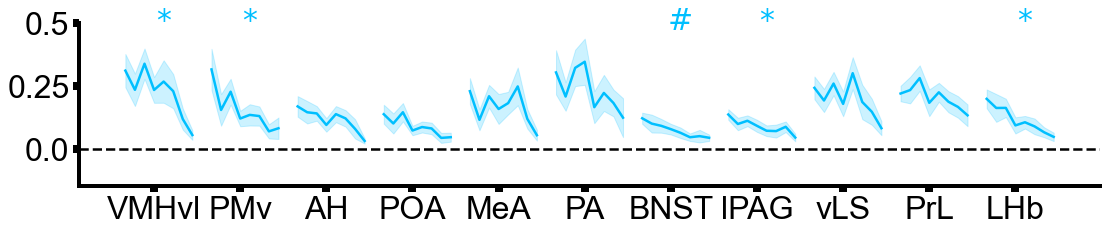

In [101]:
# AGG E and I activity

from scipy.stats import sem

bar_settings = {
    'color': 'white',
    'linewidth': 2.75,
    'capsize': 2.75,
    'error_kw': {'elinewidth': 2.5, 'capsize': 5, 'capthick': 2.5, 'markeredgewidth': 2}}


# Create a figure for the line plots
fig1, ax1 = plt.subplots(figsize=(20, 3))

# Counter for the bar plot positions
bar_counter = 0
factor = 9

indices = []

for t, roi in enumerate([EI_regions[x] for x in ascending_idx_E]):
    element_at_t = np.array([EI_regions[x] for x in ascending_idx_E])[t]
    t_hat = EI_regions.index(element_at_t)
    table = all_tables[t_hat]
    table = table.dropna(axis=0)
    table = table.reset_index(drop=True)

    # Get unique groups
    groups = table['exp_group'].unique()

    # Plot E
    group = 1
    color='forestgreen'
    if t == 11:
        color='black'
    subset = table[table['exp_group'] == group]
    means = subset.groupby('cross_day')['dependent_variable'].mean()
    errors = subset.groupby('cross_day')['dependent_variable'].apply(sem)
    ax1.plot(means.index.values + t*factor, means.values, color=color, linewidth=2.5)
    ax1.fill_between(means.index.values + t*factor, means.values - errors.values, means.values + errors.values, alpha=0.2, color=color)
    indices.append(t*factor)
    
labels=[x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(EI_regions)[ascending_idx_E]]
ax1.set_xticks((np.arange(0, 12*factor, factor)+2)+1, labels, fontsize=32, fontfamily='Arial')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim(top=0.5, bottom=-0.15)
ax1.set_yticks(np.arange(0, 0.52, 0.25));
ax1.set_yticklabels(np.arange(0, 0.52, 0.25), fontsize=32, fontfamily='Arial');
ax1.set_yticklabels(np.arange(0, 0.52, 0.25), fontsize=32, fontfamily='Arial');
ax1.axhline(0, color='black', linestyle='--', linewidth=2.5)

# Adding stars
try:
    for p_value_E, p_value_I, index in zip(p_values_OBS_E_corrected, p_values_OBS_I_corrected, indices):
        # If the p-value is less than 0.05, add a "*" above the line
        if p_value_E < 0.07:
            color = 'forestgreen' if index < 9*11 else 'black'
            if p_value_E < 0.001:
                marker = '***'
            elif p_value_E < 0.01:
                marker = '**'
            elif p_value_E < 0.05:
                marker = '*'
            else:
                marker='#'
            plt.text(index+4, 0.45, marker, ha='center', va='bottom', fontsize=30, color=color)
except ValueError:
    pass

fig2, ax2 = plt.subplots(figsize=(18.3, 3))

for t, roi in enumerate([EI_regions[x] for x in ascending_idx_I]):
    element_at_t = np.array([EI_regions[x] for x in ascending_idx_I])[t]
    t_hat = EI_regions.index(element_at_t)
    table = all_tables[t_hat]
    table = table.dropna(axis=0)
    table = table.reset_index(drop=True)

    # Get unique groups
    groups = table['exp_group'].unique()

    # Plot I
    group = 1
    color='deepskyblue'
    subset = table[table['exp_group'] == group]
    means = subset.groupby('cross_day')['dependent_variable'].mean()
    errors = subset.groupby('cross_day')['dependent_variable'].apply(sem)
    ax2.plot(means.index.values + t*factor, means.values, color=color, linewidth=2.5)
    ax2.fill_between(means.index.values + t*factor, means.values - errors.values, means.values + errors.values, alpha=0.2, color=color)
    indices.append(t*factor)

# Cleaning
labels=[x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(EI_regions)[ascending_idx_I]]
ax2.set_xticks((np.arange(0, 11*factor, factor)+2)+1, labels, fontsize=32, fontfamily='Arial')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim(top=0.5, bottom=-0.15)
ax2.set_yticks(np.arange(0, 0.52, 0.25));
ax2.set_yticklabels(np.arange(0, 0.52, 0.25), fontsize=32, fontfamily='Arial');
ax2.set_yticklabels(np.arange(0, 0.52, 0.25), fontsize=32, fontfamily='Arial');
ax2.axhline(0, color='black', linestyle='--', linewidth=2.5)

# Adding stars
try:
    for p_value_E, p_value_I, index in zip(p_values_OBS_E_corrected, p_values_OBS_I_corrected, indices):
        # If the p-value is less than 0.05, add a "*" above the line
        if p_value_I < 0.07:
            if p_value_I < 0.001:
                marker = '***'
            elif p_value_I < 0.01:
                marker = '**'
            elif p_value_I < 0.05:
                marker = '*'
            else:
                marker='#'
            plt.text(index+4, 0.45, marker, ha='center', va='bottom', fontsize=30, color='deepskyblue')
except ValueError:
    pass

# Save fig1 as an SVG file
fig1.savefig('./figures/OBS_exc_activity_changes.svg', format='svg')
fig2.savefig('./figures/OBS_inh_activity_changes.svg', format='svg')

5. Assess hard fight (Extended fig 4)

In [200]:
aggression_related_activity = all_dists[-3:, :, :]
aggression_related_activity = np.nanmedian(aggression_related_activity, axis=0)
agg_activity = aggression_related_activity[:, np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]
obs_activity = aggression_related_activity[:, np.array([12, 13, 14, 15, 16, 17, 18])]
non_activity = aggression_related_activity[:, np.array([19, 20, 21, 22, 23, 24])]

c:\Users\Jorge\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


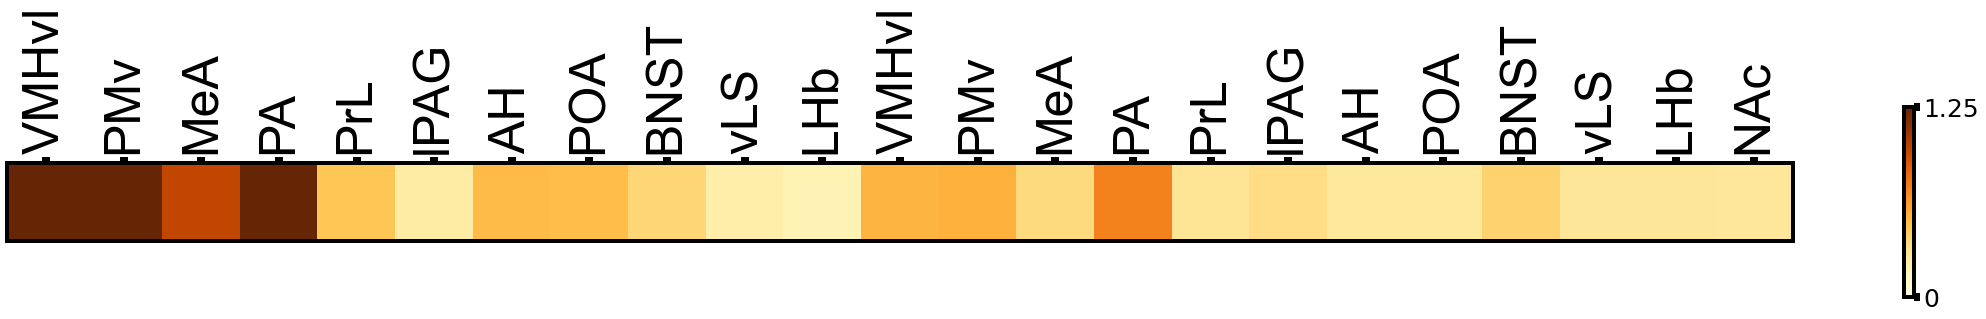

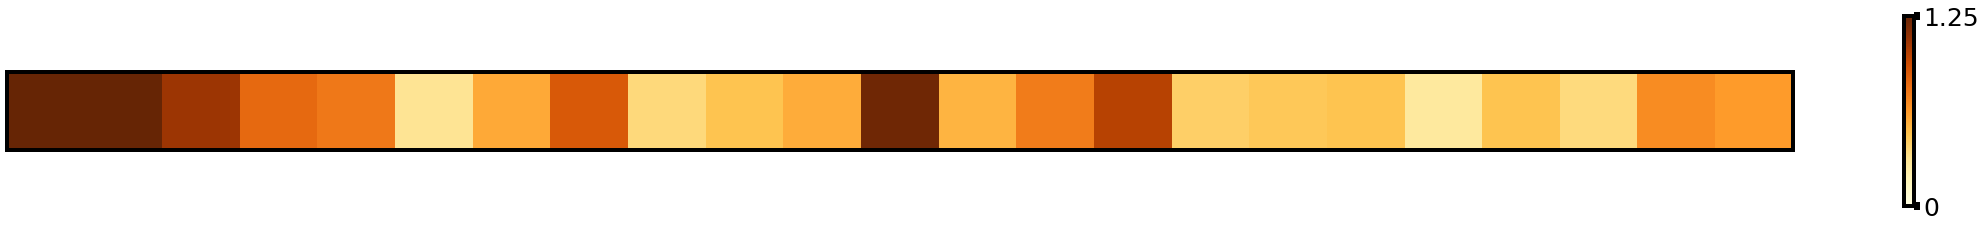

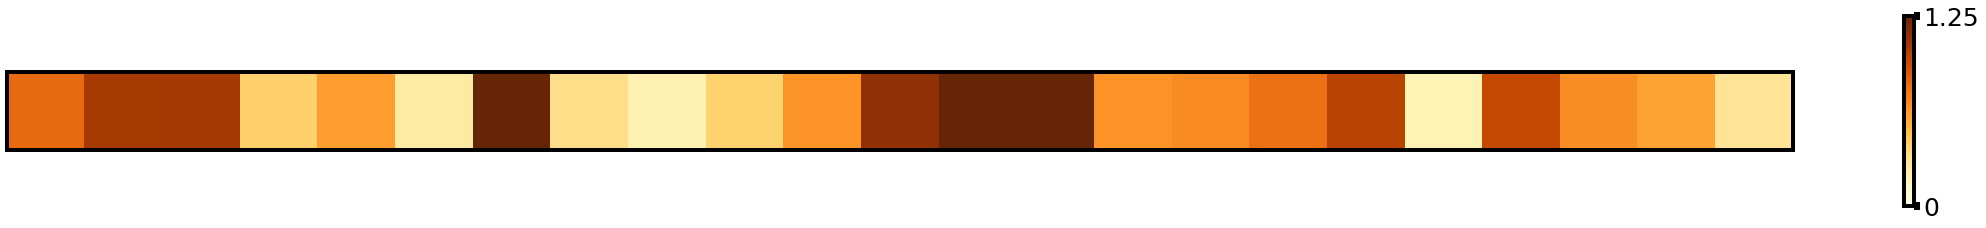

In [201]:
from matplotlib import colors
np.set_printoptions(precision=4, suppress=True)
idxs2loop = np.array([12, 16, 10, 20, 0, 14, 8, 4, 6, 2, 18, 13, 17, 11, 21, 1, 15, 9, 5, 7, 3, 19, 22])
n = len(region_ids)
cmap = 'YlOrBr'
vmin = 0.0
vmax = 1.25
all_labels = np.array([x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for x in region_ids])[idxs2loop]

# within-day change

weights = np.nanmean(agg_activity, axis=1)
weights_sorted = weights[idxs2loop]
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 1.25])
cbar.set_ticklabels([0, 1.25])
ax.set_xticks(np.arange(n), all_labels, rotation=90, fontfamily='Arial', fontsize=50);
ax.set_yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
# plt.savefig('./figures/agg_prep_HF_activity.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(obs_activity, axis=1)
weights_sorted = weights[idxs2loop]
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 1.25])
cbar.set_ticklabels([0, 1.25])
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
# # plt.savefig('./figures/obs_prep_HF_activity.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(non_activity, axis=1)
weights_sorted = weights[idxs2loop]
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(40, 10))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=[0, 1.25])
cbar.set_ticklabels([0, 1.25])
# plt.xticks(np.arange(n), np.array(regions_without_label)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
# # plt.savefig('./figures/non_prep_HF_activity.svg', dpi=600, bbox_inches='tight')




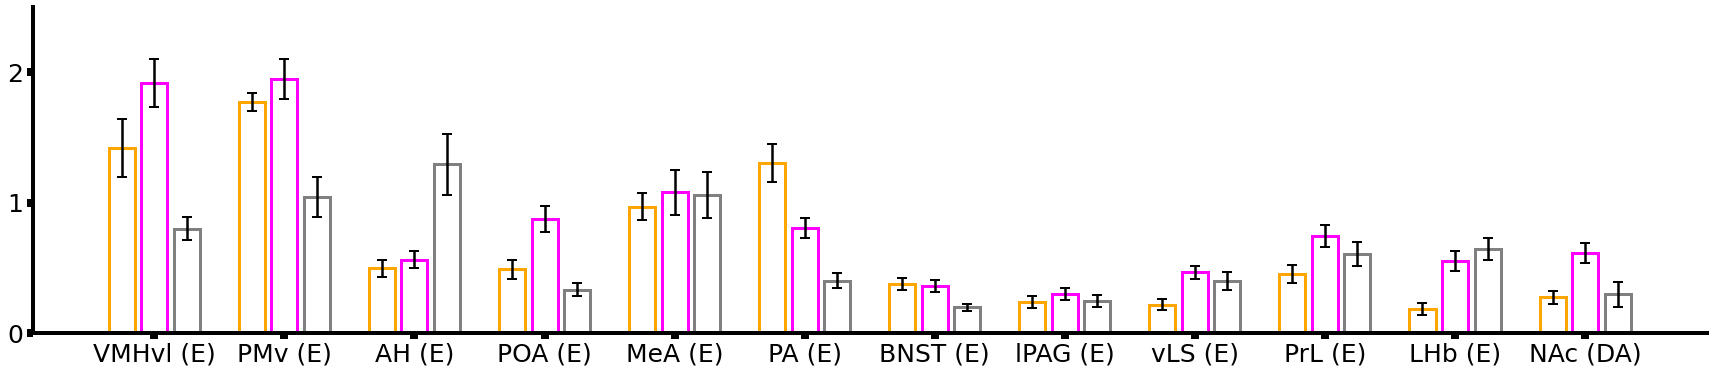

In [214]:
sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

amped_idxs = np.arange(0, 23*4, 4)
agg_diff = np.transpose(agg_activity, [1, 0])
obs_diff = np.transpose(obs_activity, [1, 0])
non_diff = np.transpose(non_activity, [1, 0])
new_region_ids = [s.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for s in region_ids]
idxs2loop = np.array([13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 23])-1

# plt.figure(figsize=(30, 5))
amped_idxs = np.arange(0, 12*4, 4)
plt.figure(figsize=(30, 6))
for r, (roi, roi_amp) in enumerate(zip(idxs2loop, amped_idxs)):
    # print(region_ids[roi])
    # run_atk_stats_ANOVA([np.nanmean(agg_diff[:, roi], axis=0), np.nanmean(obs_diff[:, roi], axis=0), np.nanmean(non_diff[:, roi], axis=0)])

    plt.bar(roi_amp, np.nanmean(agg_diff[:, roi]), color='white', edgecolor='orange', linewidth=3)
    plt.bar(roi_amp+1, np.nanmean(obs_diff[:, roi]), color='white', edgecolor='magenta', linewidth=3)
    plt.bar(roi_amp+2, np.nanmean(non_diff[:, roi]), color='white', edgecolor='gray', linewidth=3)

    plt.errorbar(roi_amp, np.nanmean(agg_diff[:, roi]), yerr=np.nanstd(agg_diff[:, roi])/np.sqrt(agg_diff.shape[1]), color='black', 
    capsize=5, markeredgewidth=2)
    plt.errorbar(roi_amp+1, np.nanmean(obs_diff[:, roi]), yerr=np.nanstd(obs_diff[:, roi])/np.sqrt(obs_diff.shape[1]), color='black', 
    capsize=5, markeredgewidth=2)
    plt.errorbar(roi_amp+2, np.nanmean(non_diff[:, roi]), yerr=np.nanstd(non_diff[:, roi])/np.sqrt(non_diff.shape[1]), color='black', 
    capsize=5, markeredgewidth=2)

plt.xticks(amped_idxs+1, [region_ids[i] for i in idxs2loop], rotation=0);
sns.despine()
plt.ylim(top=2.5, bottom=0)
plt.yticks([0, 1, 2]);
# plt.axhline(y=0, color='black', linestyle='--')
plt.savefig('./figures/excitatory_activity.svg', dpi=300)

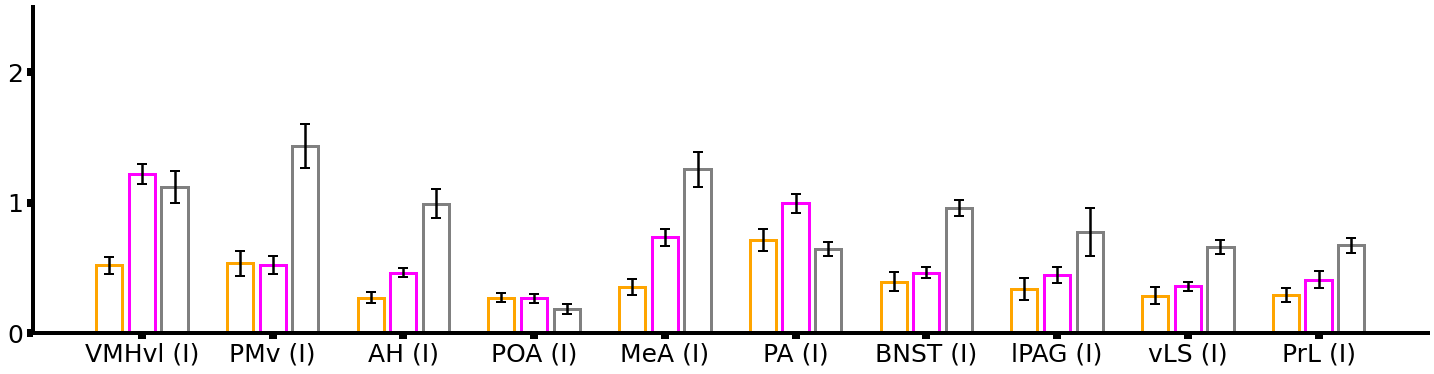

In [216]:
idxs2loop = np.array([13, 17, 11, 21, 1, 15, 9, 5, 7, 3])

sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

amped_idxs = np.arange(0, 23*4, 4)
agg_diff = np.transpose(agg_activity, [1, 0])
obs_diff = np.transpose(obs_activity, [1, 0])
non_diff = np.transpose(non_activity, [1, 0])
new_region_ids = [s.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for s in region_ids]
idxs2loop = np.array([13, 17, 9, 5, 11, 21, 7, 15, 3, 1])

# plt.figure(figsize=(30, 5))
amped_idxs = np.arange(0, 10*4, 4)
plt.figure(figsize=(25, 6))
for r, (roi, roi_amp) in enumerate(zip(idxs2loop, amped_idxs)):
    # print(region_ids[roi])
    # run_atk_stats_ANOVA([np.nanmean(agg_diff[:, roi], axis=0), np.nanmean(obs_diff[:, roi], axis=0), np.nanmean(non_diff[:, roi], axis=0)])

    plt.bar(roi_amp, np.nanmean(agg_diff[:, roi]), color='white', edgecolor='orange', linewidth=3)
    plt.bar(roi_amp+1, np.nanmean(obs_diff[:, roi]), color='white', edgecolor='magenta', linewidth=3)
    plt.bar(roi_amp+2, np.nanmean(non_diff[:, roi]), color='white', edgecolor='gray', linewidth=3)

    plt.errorbar(roi_amp, np.nanmean(agg_diff[:, roi]), yerr=np.nanstd(agg_diff[:, roi])/np.sqrt(agg_diff.shape[1]), color='black', 
    capsize=5, markeredgewidth=2)
    plt.errorbar(roi_amp+1, np.nanmean(obs_diff[:, roi]), yerr=np.nanstd(obs_diff[:, roi])/np.sqrt(obs_diff.shape[1]), color='black', 
    capsize=5, markeredgewidth=2)
    plt.errorbar(roi_amp+2, np.nanmean(non_diff[:, roi]), yerr=np.nanstd(non_diff[:, roi])/np.sqrt(non_diff.shape[1]), color='black', 
    capsize=5, markeredgewidth=2)

plt.xticks(amped_idxs+1, [region_ids[i] for i in idxs2loop], rotation=0);
sns.despine()
plt.ylim(top=2.5, bottom=0)
plt.yticks([0, 1, 2]);
# plt.axhline(y=0, color='black', linestyle='--')
plt.savefig('./figures/inhibitory_activity.svg', dpi=300)

In [203]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

for r, roi in enumerate(region_ids):
    print(' ##### %s ##### ' % roi)
    agg_roi_activity = agg_activity[r, :][np.isnan(agg_activity[r, :])==False]
    obs_roi_activity = obs_activity[r, :][np.isnan(obs_activity[r, :])==False]
    non_roi_activity = non_activity[r, :][np.isnan(non_activity[r, :])==False]

    # Add the data to the DataFrame
    df = pd.DataFrame({
        'Activity': np.concatenate([agg_roi_activity, obs_roi_activity, non_roi_activity]),
        'Group': np.concatenate([['agg'] * len(agg_roi_activity), ['obs'] * len(obs_roi_activity), ['non'] * len(non_roi_activity)]),
    })

    # Test for normality
    _, p_agg = stats.shapiro(agg_roi_activity)
    _, p_obs = stats.shapiro(obs_roi_activity)
    _, p_non = stats.shapiro(non_roi_activity)
    
    if p_agg > 0.05 and p_obs > 0.05 and p_non > 0.05:
        # Perform the one-way ANOVA
        model = sm.OLS.from_formula('Activity ~ C(Group)', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print("F = %f, p = %f" % (anova_table['F'][0], anova_table['PR(>F)'][0]))
        if anova_table['PR(>F)'][0] <= 0.1:
            t1, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
            t2, p_obs_non = stats.ttest_ind(obs_roi_activity, non_roi_activity)
            t3, p_agg_obs = stats.ttest_ind(agg_roi_activity, obs_roi_activity)
            multiple_tests = multipletests([p_agg_non, p_agg_obs, p_obs_non], method='fdr_tsbh')
            print('AGG vs NON; t = %f, p = %f' % (t1, multiple_tests[1][0]))
            print('AGG vs OBS; t = %f, p = %f' % (t3, multiple_tests[1][1]))
            print('OBS vs NON; t = %f, p = %f' % (t2, multiple_tests[1][2]))
    else:
        # Perform Kruskal-Wallis H-test
        kruskal_result = stats.kruskal(agg_roi_activity, obs_roi_activity, non_roi_activity)
        print("H = %f, p = %f" % (kruskal_result.statistic, kruskal_result.pvalue))
        if kruskal_result.pvalue <= 0.1:
            t1, p_agg_non = stats.mannwhitneyu(agg_roi_activity, non_roi_activity)
            t2, p_obs_non = stats.mannwhitneyu(obs_roi_activity, non_roi_activity)
            t3, p_agg_obs = stats.mannwhitneyu(agg_roi_activity, obs_roi_activity)
            multiple_tests = multipletests([p_agg_non, p_agg_obs, p_obs_non], method='fdr_tsbh')
            print('AGG vs NON; U = %f, p = %f' % (t1, multiple_tests[1][0]))
            print('AGG vs OBS; U = %f, p = %f' % (t3, multiple_tests[1][1]))
            print('OBS vs NON; U = %f, p = %f' % (t2, multiple_tests[1][2]))
    print('###')

 ##### PrL (E) ##### 
F = 1.077960, p = 0.358386
###
 ##### PrL (I) ##### 
F = 2.946660, p = 0.074479
AGG vs NON; t = -2.543588, p = 0.067446
AGG vs OBS; t = -0.784294, p = 0.444325
OBS vs NON; t = -1.438913, p = 0.267024
###
 ##### vLS (E) ##### 
F = 2.285984, p = 0.125311
###
 ##### vLS (I) ##### 
H = 7.522857, p = 0.023251
AGG vs NON; U = 10.000000, p = 0.026934
AGG vs OBS; U = 29.000000, p = 0.199413
OBS vs NON; U = 6.000000, p = 0.034965
###
 ##### POA (E) ##### 
F = 3.375398, p = 0.053569
AGG vs NON; t = 0.921370, p = 0.371439
AGG vs OBS; t = -1.856299, p = 0.122884
OBS vs NON; t = 2.324319, p = 0.120811
###
 ##### POA (I) ##### 
F = 0.511588, p = 0.606825
###
 ##### BNST (E) ##### 
F = 1.378370, p = 0.274916
###
 ##### BNST (I) ##### 
H = 9.561077, p = 0.008391
AGG vs NON; U = 5.000000, p = 0.004079
AGG vs OBS; U = 25.000000, p = 0.121281
OBS vs NON; U = 3.000000, p = 0.004079
###
 ##### AH (E) ##### 
F = 2.829230, p = 0.082793
AGG vs NON; t = -1.964262, p = 0.209011
AGG vs OBS;

Repeat but with nonsocial behavior:

In [244]:
def compute_activity(grid, n_clusters, n_animals=12):

    activity_grid = np.zeros((len(n_clusters), len(region_ids), grid.shape[2], n_animals))
    activity_grid[:] = np.nan

    for a in range(grid.shape[-1]):
        for i, idx in enumerate(region_ids): # E indices
            activity = grid[n_clusters, i, :, a] # if clusters are selected monotonically
            activity_grid[:, i, :, a] = activity

    return activity_grid

# For computing EI indices
total_sessions = 27
n_animals = 25
n_rois = len(region_ids)

# Gra activity during aggression subclusters
n_clusters = np.arange(10)
# n_clusters = np.arange(8)
prep_activity_data = compute_activity(all_activity, n_clusters=np.array(n_clusters), n_animals=n_animals) 
n_clusters = [10, 11, 12]
asocial_activity_data = compute_activity(all_activity, n_clusters=np.array(n_clusters), n_animals=n_animals)

# For saving
prep_dists = np.zeros((total_sessions, n_rois, n_animals))
prep_dists[:] = np.nan
asocial_dists = prep_dists.copy()

for animal in np.arange(prep_activity_data.shape[-1]):
    for roi in np.arange(n_rois):
        sample1 = prep_activity_data[:, roi, :, animal]
        sample2 = asocial_activity_data[:, roi, :, animal]
        for i in enumerate(np.arange(sample1.shape[1])):
            prep_dists[i,roi,animal] = np.mean(prep_activity_data[:, roi, i, animal])
            asocial_dists[i,roi,animal] = np.mean(asocial_activity_data[:, roi, i, animal])

all_dists = asocial_dists.copy()

In [245]:
aggression_related_activity = all_dists[-3:, :, :]
aggression_related_activity = np.nanmedian(aggression_related_activity, axis=0)
agg_activity = aggression_related_activity[:, np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]
obs_activity = aggression_related_activity[:, np.array([12, 13, 14, 15, 16, 17, 18])]
non_activity = aggression_related_activity[:, np.array([19, 20, 21, 22, 23, 24])]

C:\Users\Jorge\AppData\Local\Temp\ipykernel_71000\3362181440.py:1: RuntimeWarning: Mean of empty slice
  aggression_related_activity = all_dists[-3:, :, :] - np.nanmean(all_dists[:3, :, :], axis=0)
c:\Users\Jorge\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


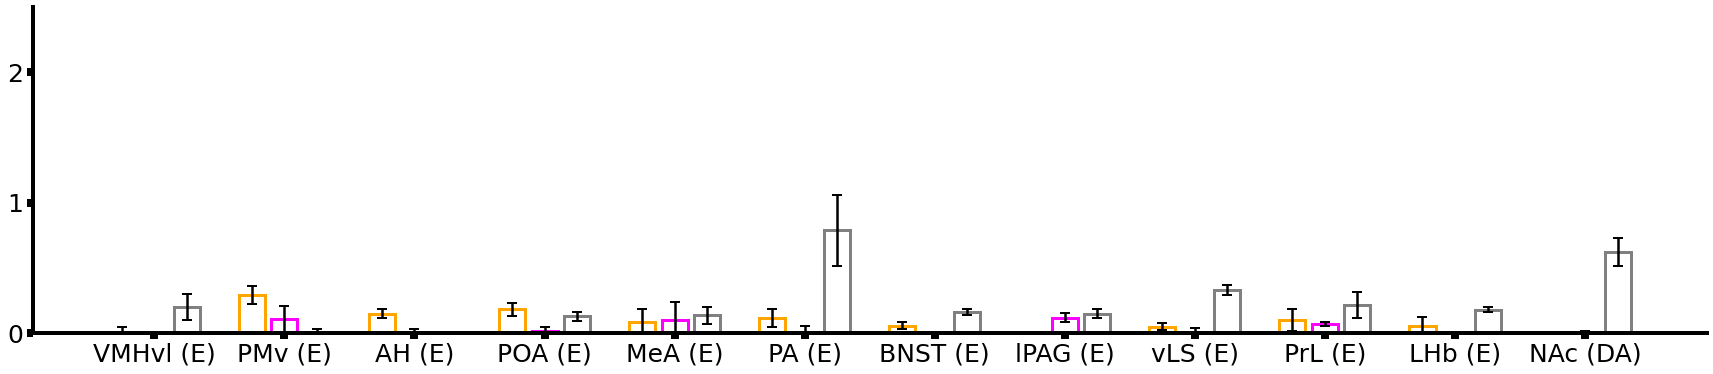

In [246]:
sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

amped_idxs = np.arange(0, 23*4, 4)
agg_diff = np.transpose(agg_activity, [1, 0])
obs_diff = np.transpose(obs_activity, [1, 0])
non_diff = np.transpose(non_activity, [1, 0])
new_region_ids = [s.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for s in region_ids]
idxs2loop = np.array([13, 17, 9, 5, 11, 21, 7, 15, 3, 1, 19, 23])-1

# plt.figure(figsize=(30, 5))
amped_idxs = np.arange(0, 12*4, 4)
plt.figure(figsize=(30, 6))
for r, (roi, roi_amp) in enumerate(zip(idxs2loop, amped_idxs)):
    # print(region_ids[roi])
    # run_atk_stats_ANOVA([np.nanmean(agg_diff[:, roi], axis=0), np.nanmean(obs_diff[:, roi], axis=0), np.nanmean(non_diff[:, roi], axis=0)])

    plt.bar(roi_amp, np.nanmean(agg_diff[:, roi]), color='white', edgecolor='orange', linewidth=3)
    plt.bar(roi_amp+1, np.nanmean(obs_diff[:, roi]), color='white', edgecolor='magenta', linewidth=3)
    plt.bar(roi_amp+2, np.nanmean(non_diff[:, roi]), color='white', edgecolor='gray', linewidth=3)

    plt.errorbar(roi_amp, np.nanmean(agg_diff[:, roi]), yerr=np.nanstd(agg_diff[:, roi])/np.sqrt(agg_diff.shape[1]), color='black', 
    capsize=5, markeredgewidth=2)
    plt.errorbar(roi_amp+1, np.nanmean(obs_diff[:, roi]), yerr=np.nanstd(obs_diff[:, roi])/np.sqrt(obs_diff.shape[1]), color='black', 
    capsize=5, markeredgewidth=2)
    plt.errorbar(roi_amp+2, np.nanmean(non_diff[:, roi]), yerr=np.nanstd(non_diff[:, roi])/np.sqrt(non_diff.shape[1]), color='black', 
    capsize=5, markeredgewidth=2)

plt.xticks(amped_idxs+1, [region_ids[i] for i in idxs2loop], rotation=0);
sns.despine()
plt.ylim(top=2.5, bottom=0)
plt.yticks([0, 1, 2]);
# plt.axhline(y=0, color='black', linestyle='--')
# plt.savefig('./figures/excitatory_activity.svg', dpi=300)

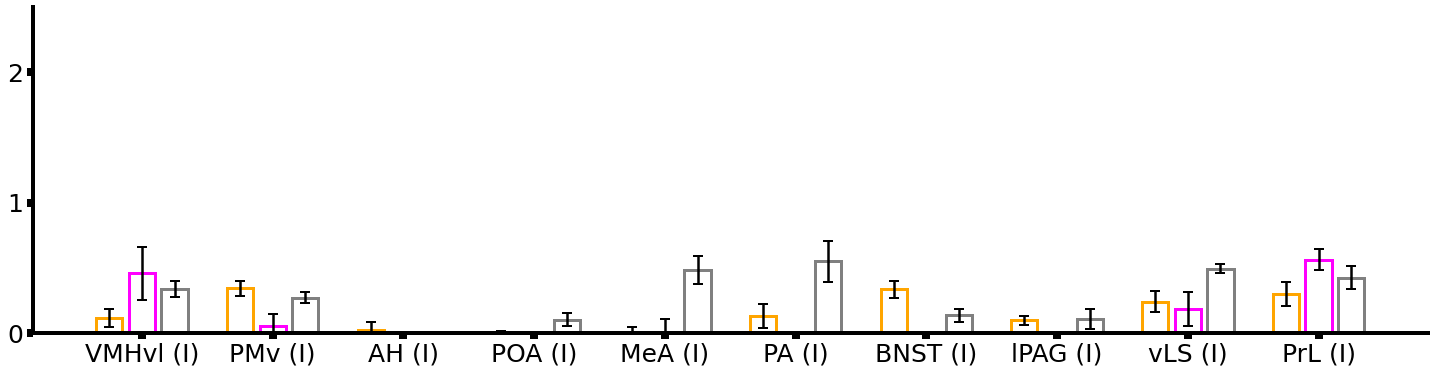

In [247]:
idxs2loop = np.array([13, 17, 11, 21, 1, 15, 9, 5, 7, 3])

sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

amped_idxs = np.arange(0, 23*4, 4)
agg_diff = np.transpose(agg_activity, [1, 0])
obs_diff = np.transpose(obs_activity, [1, 0])
non_diff = np.transpose(non_activity, [1, 0])
new_region_ids = [s.replace(' (E)', '').replace(' (I)', '').replace(' (DA)', '') for s in region_ids]
idxs2loop = np.array([13, 17, 9, 5, 11, 21, 7, 15, 3, 1])

# plt.figure(figsize=(30, 5))
amped_idxs = np.arange(0, 10*4, 4)
plt.figure(figsize=(25, 6))
for r, (roi, roi_amp) in enumerate(zip(idxs2loop, amped_idxs)):
    # print(region_ids[roi])
    # run_atk_stats_ANOVA([np.nanmean(agg_diff[:, roi], axis=0), np.nanmean(obs_diff[:, roi], axis=0), np.nanmean(non_diff[:, roi], axis=0)])

    plt.bar(roi_amp, np.nanmean(agg_diff[:, roi]), color='white', edgecolor='orange', linewidth=3)
    plt.bar(roi_amp+1, np.nanmean(obs_diff[:, roi]), color='white', edgecolor='magenta', linewidth=3)
    plt.bar(roi_amp+2, np.nanmean(non_diff[:, roi]), color='white', edgecolor='gray', linewidth=3)

    plt.errorbar(roi_amp, np.nanmean(agg_diff[:, roi]), yerr=np.nanstd(agg_diff[:, roi])/np.sqrt(agg_diff.shape[1]), color='black', 
    capsize=5, markeredgewidth=2)
    plt.errorbar(roi_amp+1, np.nanmean(obs_diff[:, roi]), yerr=np.nanstd(obs_diff[:, roi])/np.sqrt(obs_diff.shape[1]), color='black', 
    capsize=5, markeredgewidth=2)
    plt.errorbar(roi_amp+2, np.nanmean(non_diff[:, roi]), yerr=np.nanstd(non_diff[:, roi])/np.sqrt(non_diff.shape[1]), color='black', 
    capsize=5, markeredgewidth=2)

plt.xticks(amped_idxs+1, [region_ids[i] for i in idxs2loop], rotation=0);
sns.despine()
plt.ylim(top=2.5, bottom=0)
plt.yticks([0, 1, 2]);
# plt.axhline(y=0, color='black', linestyle='--')
# plt.savefig('./figures/inhibitory_activity.svg', dpi=300)

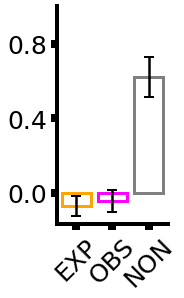

In [258]:
plt.figure(figsize=(2, 4))
roi = 22
plt.bar(0, np.nanmean(agg_diff[:, roi]), color='white', edgecolor='orange', linewidth=3)
plt.bar(1, np.nanmean(obs_diff[:, roi]), color='white', edgecolor='magenta', linewidth=3)
plt.bar(2, np.nanmean(non_diff[:, roi]), color='white', edgecolor='gray', linewidth=3)

plt.errorbar(0, np.nanmean(agg_diff[:, roi]), yerr=np.nanstd(agg_diff[:, roi])/np.sqrt(agg_diff.shape[1]), color='black', 
capsize=5, markeredgewidth=2)
plt.errorbar(1, np.nanmean(obs_diff[:, roi]), yerr=np.nanstd(obs_diff[:, roi])/np.sqrt(obs_diff.shape[1]), color='black', 
capsize=5, markeredgewidth=2)
plt.errorbar(2, np.nanmean(non_diff[:, roi]), yerr=np.nanstd(non_diff[:, roi])/np.sqrt(non_diff.shape[1]), color='black', 
capsize=5, markeredgewidth=2)

plt.ylim(top=1)
plt.yticks([0, 0.4, 0.8])
plt.xticks([0, 1, 2], ['EXP', 'OBS', 'NON'], rotation=45)

sns.despine()
plt.savefig('./figures/nonsocial_NAc_activity.svg', dpi=300)

In [248]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

for r, roi in enumerate(region_ids):
    print(' ##### %s ##### ' % roi)
    agg_roi_activity = agg_activity[r, :][np.isnan(agg_activity[r, :])==False]
    obs_roi_activity = obs_activity[r, :][np.isnan(obs_activity[r, :])==False]
    non_roi_activity = non_activity[r, :][np.isnan(non_activity[r, :])==False]

    # Add the data to the DataFrame
    df = pd.DataFrame({
        'Activity': np.concatenate([agg_roi_activity, obs_roi_activity, non_roi_activity]),
        'Group': np.concatenate([['agg'] * len(agg_roi_activity), ['obs'] * len(obs_roi_activity), ['non'] * len(non_roi_activity)]),
    })

    # Test for normality
    _, p_agg = stats.shapiro(agg_roi_activity)
    _, p_obs = stats.shapiro(obs_roi_activity)
    _, p_non = stats.shapiro(non_roi_activity)
    
    if p_agg > 0.05 and p_obs > 0.05 and p_non > 0.05:
        # Perform the one-way ANOVA
        model = sm.OLS.from_formula('Activity ~ C(Group)', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print("F = %f, p = %f" % (anova_table['F'][0], anova_table['PR(>F)'][0]))
        if anova_table['PR(>F)'][0] <= 0.1:
            t1, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
            t2, p_obs_non = stats.ttest_ind(obs_roi_activity, non_roi_activity)
            t3, p_agg_obs = stats.ttest_ind(agg_roi_activity, obs_roi_activity)
            multiple_tests = multipletests([p_agg_non, p_agg_obs, p_obs_non], method='fdr_tsbh')
            print('AGG vs NON; t = %f, p = %f' % (t1, multiple_tests[1][0]))
            print('AGG vs OBS; t = %f, p = %f' % (t3, multiple_tests[1][1]))
            print('OBS vs NON; t = %f, p = %f' % (t2, multiple_tests[1][2]))
    else:
        # Perform Kruskal-Wallis H-test
        kruskal_result = stats.kruskal(agg_roi_activity, obs_roi_activity, non_roi_activity)
        print("H = %f, p = %f" % (kruskal_result.statistic, kruskal_result.pvalue))
        if kruskal_result.pvalue <= 0.1:
            t1, p_agg_non = stats.mannwhitneyu(agg_roi_activity, non_roi_activity)
            t2, p_obs_non = stats.mannwhitneyu(obs_roi_activity, non_roi_activity)
            t3, p_agg_obs = stats.mannwhitneyu(agg_roi_activity, obs_roi_activity)
            multiple_tests = multipletests([p_agg_non, p_agg_obs, p_obs_non], method='fdr_tsbh')
            print('AGG vs NON; U = %f, p = %f' % (t1, multiple_tests[1][0]))
            print('AGG vs OBS; U = %f, p = %f' % (t3, multiple_tests[1][1]))
            print('OBS vs NON; U = %f, p = %f' % (t2, multiple_tests[1][2]))
    print('###')

 ##### PrL (E) ##### 
F = 0.253551, p = 0.778382
###
 ##### PrL (I) ##### 
F = 0.748315, p = 0.485366
###
 ##### vLS (E) ##### 
H = 8.719780, p = 0.012780
AGG vs NON; U = 7.000000, p = 0.004740
AGG vs OBS; U = 48.000000, p = 0.216784
OBS vs NON; U = 4.000000, p = 0.006993
###
 ##### vLS (I) ##### 
F = 0.824379, p = 0.451604
###
 ##### POA (E) ##### 
F = 1.448548, p = 0.257442
###
 ##### POA (I) ##### 
H = 3.088139, p = 0.213511
###
 ##### BNST (E) ##### 
F = 2.638425, p = 0.096177
AGG vs NON; t = -1.454795, p = 0.222717
AGG vs OBS; t = 1.272069, p = 0.222717
OBS vs NON; t = -2.037995, p = 0.198998
###
 ##### BNST (I) ##### 
F = 4.615110, p = 0.022489
AGG vs NON; t = 1.290696, p = 0.145145
AGG vs OBS; t = 2.952678, p = 0.019759
OBS vs NON; t = -1.688276, p = 0.119472
###
 ##### AH (E) ##### 
F = 2.983888, p = 0.073443
AGG vs NON; t = 2.330188, p = 0.105807
AGG vs OBS; t = 1.633863, p = 0.184644
OBS vs NON; t = 0.838887, p = 0.419390
###
 ##### AH (I) ##### 
H = 0.757660, p = 0.684662
##

### Raw data with labels (Fig 2)

1. Hard fight

In [ ]:
sample = full_data['30L_d9_mCD1_t1']

plt.figure(figsize=(7, 20))
indices = []
scale = 5
range_of_values = [1500, 4000]
for c, column in enumerate(sample.columns[:-2]): 
    if c % 2 == 0 and c != 22:
        plt.plot(sample[column].values[range_of_values[0]:range_of_values[1]] + c * scale, color='red', linewidth=1.5)
        indices.append(c * scale)
    elif c == 22:
        plt.plot(sample[column].values[range_of_values[0]:range_of_values[1]] + c * scale, color='black', linewidth=1.5)
        indices.append(c * scale)
    else:
        plt.plot(sample[column].values[range_of_values[0]:range_of_values[1]] + (c-1) * scale, color='blue', linewidth=1.5, alpha=0.7)
plt.yticks(np.array(indices)+2, ['PrL', 'vLS', 'POA', 'BNST', 'AH', 'MeA', 'VMH', 'PAG', 'PMv', 'LHb', 'PA', 'NAc'], fontsize=40, fontfamily='Arial');
# plt.xticks(np.arange(0, 2500, 500), np.arange(0, 2500/40, 500/40).astype(int), fontsize=40, fontfamily='Arial');
plt.xticks([])
ax = plt.gca()
ax.tick_params(axis='y', which='both', length=0)
sns.despine(bottom=True, left=True)
plt.savefig('.\\figures\\paper_figs\\network_activity.svg', dpi=600, bbox_inches='tight')


In [ ]:
sample = full_data['30L_d9_mCD1_t1']
unsup_behaviors = sample['unsupervised labels']
unsupervised_binary_labels = np.zeros((len(unsup_behaviors), len(clusters)))
for i, label in enumerate(unsup_behaviors):
	unsupervised_binary_labels[i, int(label)-1] = 1

range_of_values = [1500, 4000]
supervised_binary_labels = sample['attack labels'].values[range_of_values[0]:range_of_values[1]]
unsupervised_binary_labels = unsupervised_binary_labels[range_of_values[0]:range_of_values[1], :]

In [ ]:
warm_dark_colors = ['red', 'red', 'red', 'red', 'red', 'tomato', 'tomato', 'tomato','tomato', 'tomato', 'burlywood', 'burlywood', 'burlywood']
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 1))
for i, label in enumerate(supervised_binary_labels):
    color = 'darkred' if label == 1 else 'white'
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color, edgecolor='black'))
ax.set_xlim(0, len(supervised_binary_labels))
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.savefig('.\\figures\\paper_figs\\attack_labels.svg', dpi=600, bbox_inches='tight')

for cluster in range(unsupervised_binary_labels.shape[1]):
    fig, ax = plt.subplots(figsize=(10, 1))
    for i, label in enumerate(unsupervised_binary_labels[:, cluster]):
        color = warm_dark_colors[cluster] if label == 1 else 'white'
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color, edgecolor='black'))
    ax.set_xlim(0, len(supervised_binary_labels))
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.savefig('.\\figures\\paper_figs\\cluster_%d_labels.svg' % cluster, dpi=600, bbox_inches='tight')


2. Training period (AGG)

In [ ]:
sample = full_data['30L_d2_balbc_t1']

plt.figure(figsize=(7, 20))
indices = []
scale = 5
range_of_values = [500, 3000] # keep it 2500
for c, column in enumerate(sample.columns[:-2]): 
    if c % 2 == 0 and c != 22:
        plt.plot(sample[column].values[range_of_values[0]:range_of_values[1]] + c * scale, color='red', linewidth=1.5)
        indices.append(c * scale)
    elif c == 22:
        plt.plot(sample[column].values[range_of_values[0]:range_of_values[1]] + c * scale, color='black', linewidth=1.5)
        indices.append(c * scale)
    else:
        plt.plot(sample[column].values[range_of_values[0]:range_of_values[1]] + (c-1) * scale, color='blue', linewidth=1.5, alpha=0.7)
plt.yticks(np.array(indices)+2, ['PrL', 'vLS', 'POA', 'BNST', 'AH', 'MeA', 'VMH', 'PAG', 'PMv', 'LHb', 'PA', 'NAc'], fontsize=40, fontfamily='Arial');
# plt.xticks(np.arange(0, 2500, 500), np.arange(0, 2500/40, 500/40).astype(int), fontsize=40, fontfamily='Arial');
plt.xticks([])
ax = plt.gca()
ax.tick_params(axis='y', which='both', length=0)
sns.despine(bottom=True, left=True)
plt.savefig('./figures/trainingPeriod_activity.svg', dpi=600, bbox_inches='tight')


In [ ]:
unsup_behaviors = sample['unsupervised labels']
unsupervised_binary_labels = np.zeros((len(unsup_behaviors), len(clusters)))
for i, label in enumerate(unsup_behaviors):
	unsupervised_binary_labels[i, int(label)-1] = 1

supervised_binary_labels = sample['attack labels'].values[range_of_values[0]:range_of_values[1]]
unsupervised_binary_labels = unsupervised_binary_labels[range_of_values[0]:range_of_values[1], :]

In [ ]:
warm_dark_colors = ['red', 'red', 'red', 'red', 'red', 'tomato', 'tomato', 'tomato','tomato', 'tomato', 'burlywood', 'burlywood', 'burlywood']
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 1))
for i, label in enumerate(supervised_binary_labels):
    color = 'darkred' if label == 1 else 'white'
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color, edgecolor='black'))
ax.set_xlim(0, len(supervised_binary_labels))
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.savefig('./figures/TP_attack_labels.svg', dpi=600, bbox_inches='tight')

for cluster in range(unsupervised_binary_labels.shape[1]):
    fig, ax = plt.subplots(figsize=(10, 1))
    for i, label in enumerate(unsupervised_binary_labels[:, cluster]):
        color = warm_dark_colors[cluster] if label == 1 else 'white'
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color, edgecolor='black'))
    ax.set_xlim(0, len(supervised_binary_labels))
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.savefig('./figures/TP_cluster_%d_labels.svg' % cluster, dpi=600, bbox_inches='tight')


3. Training period (OBS)

In [ ]:
sample = full_data['30R2_d2_obs_t1']

plt.figure(figsize=(7, 20))
indices = []
scale = 5
range_of_values = [1500, 4000] # keep it 2500
for c, column in enumerate(sample.columns[:-2]): 
    if c % 2 == 0 and c != 22:
        plt.plot(sample[column].values[range_of_values[0]:range_of_values[1]] + c * scale, color='red', linewidth=1.5)
        indices.append(c * scale)
    elif c == 22:
        plt.plot(sample[column].values[range_of_values[0]:range_of_values[1]] + c * scale, color='black', linewidth=1.5)
        indices.append(c * scale)
    else:
        plt.plot(sample[column].values[range_of_values[0]:range_of_values[1]] + (c-1) * scale, color='blue', linewidth=1.5, alpha=0.7)
plt.yticks(np.array(indices)+2, ['PrL', 'vLS', 'POA', 'BNST', 'AH', 'MeA', 'VMH', 'PAG', 'PMv', 'LHb', 'PA', 'NAc'], fontsize=40, fontfamily='Arial');
# plt.xticks(np.arange(0, 2500, 500), np.arange(0, 2500/40, 500/40).astype(int), fontsize=40, fontfamily='Arial');
plt.xticks([])
ax = plt.gca()
ax.tick_params(axis='y', which='both', length=0)
sns.despine(bottom=True, left=True)
plt.savefig('./figures/obs_activity.svg', dpi=600, bbox_inches='tight')


In [ ]:
unsup_behaviors = sample['unsupervised labels']
unsupervised_binary_labels = np.zeros((len(unsup_behaviors), len(clusters)))
for i, label in enumerate(unsup_behaviors):
	unsupervised_binary_labels[i, int(label)-1] = 1

supervised_binary_labels = sample['attack labels'].values[range_of_values[0]:range_of_values[1]]
unsupervised_binary_labels = unsupervised_binary_labels[range_of_values[0]:range_of_values[1], :]

In [ ]:
warm_dark_colors = ['red', 'red', 'red', 'red', 'red', 'tomato', 'tomato', 'tomato','tomato', 'tomato', 'burlywood', 'burlywood', 'burlywood']
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 1))
for i, label in enumerate(supervised_binary_labels):
    color = 'darkred' if label == 1 else 'white'
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color, edgecolor='black'))
ax.set_xlim(0, len(supervised_binary_labels))
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.savefig('./figures/TP_obs_attack_labels.svg', dpi=600, bbox_inches='tight')

for cluster in range(unsupervised_binary_labels.shape[1]):
    fig, ax = plt.subplots(figsize=(10, 1))
    for i, label in enumerate(unsupervised_binary_labels[:, cluster]):
        color = warm_dark_colors[cluster] if label == 1 else 'white'
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color, edgecolor='black'))
    ax.set_xlim(0, len(supervised_binary_labels))
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.savefig('./figures/TP_obs_cluster_%d_labels.svg' % cluster, dpi=600, bbox_inches='tight')


4. Training period (NON)

In [ ]:
sample = full_data['87L_d4_toy_t1']

plt.figure(figsize=(7, 20))
indices = []
scale = 5
range_of_values = [4500, 7000] # keep it 2500
for c, column in enumerate(sample.columns[:-2]): 
    if c % 2 == 0 and c != 22:
        plt.plot(sample[column].values[range_of_values[0]:range_of_values[1]] + c * scale, color='red', linewidth=1.5)
        indices.append(c * scale)
    elif c == 22:
        plt.plot(sample[column].values[range_of_values[0]:range_of_values[1]] + c * scale, color='black', linewidth=1.5)
        indices.append(c * scale)
    else:
        plt.plot(sample[column].values[range_of_values[0]:range_of_values[1]] + (c-1) * scale, color='blue', linewidth=1.5, alpha=0.7)
plt.yticks(np.array(indices)+2, ['PrL', 'vLS', 'POA', 'BNST', 'AH', 'MeA', 'VMH', 'PAG', 'PMv', 'LHb', 'PA', 'NAc'], fontsize=40, fontfamily='Arial');
# plt.xticks(np.arange(0, 2500, 500), np.arange(0, 2500/40, 500/40).astype(int), fontsize=40, fontfamily='Arial');
plt.xticks([])
ax = plt.gca()
ax.tick_params(axis='y', which='both', length=0)
sns.despine(bottom=True, left=True)
plt.savefig('./figures/non_activity.svg', dpi=600, bbox_inches='tight')


In [ ]:
sample = full_data['3095_d5_balbc_t3']
s = 10000
range_of_values = [s, s+2500]
unsup_behaviors = sample['unsupervised labels']
unsupervised_binary_labels = np.zeros((len(unsup_behaviors), len(clusters)))
for i, label in enumerate(unsup_behaviors):
	unsupervised_binary_labels[i, int(label)-1] = 1

supervised_binary_labels = sample['attack labels'].values[range_of_values[0]:range_of_values[1]]
unsupervised_binary_labels = unsupervised_binary_labels[range_of_values[0]:range_of_values[1], :]

In [ ]:
warm_dark_colors = ['red', 'red', 'red', 'red', 'red', 'tomato', 'tomato', 'tomato','tomato', 'tomato', 'burlywood', 'burlywood', 'burlywood']
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 1))
for i, label in enumerate(supervised_binary_labels):
    color = 'darkred' if label == 1 else 'white'
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color, edgecolor='black'))
ax.set_xlim(0, len(supervised_binary_labels))
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.savefig('./figures/TP_non_attack_labels.svg', dpi=600, bbox_inches='tight')

for cluster in range(unsupervised_binary_labels.shape[1]):
    fig, ax = plt.subplots(figsize=(10, 1))
    for i, label in enumerate(unsupervised_binary_labels[:, cluster]):
        color = warm_dark_colors[cluster] if label == 1 else 'white'
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color, edgecolor='black'))
    ax.set_xlim(0, len(supervised_binary_labels))
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.savefig('./figures/TP_non_cluster_%d_labels.svg' % cluster, dpi=600, bbox_inches='tight')
